In [64]:
import pandas as pd
import spotipy
import spotipy.util as util
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from tqdm import tqdm_notebook
from google.cloud import language_v1
from google.cloud.language_v1 import enums
import six
import os
from scipy import optimize

In [7]:
key_file = 'assets/keys.json'
keys = json.load(open(key_file))

SPOTIPY_CLIENT_ID= keys["client_id"]
SPOTIPY_CLIENT_SECRET= keys["client_secret"]
SPOTIPY_REDIRECT_URI= keys["redirect_url"]

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/carlosortega/Documents/GitHub/SUSA-Research-MusicMoods/assets/google_keys.json"

In [8]:
token = util.prompt_for_user_token("1274418332", 
                                   scope = "user-library-read", 
                                   client_id=SPOTIPY_CLIENT_ID, 
                                   client_secret=SPOTIPY_CLIENT_SECRET, 
                                   redirect_uri = SPOTIPY_REDIRECT_URI)
spotify = spotipy.Spotify(auth=token)

In [6]:
billboard = pd.read_csv("data/billboard_lyrics_1964-2015.csv")
billboard['Query'] = 'artist: ' + billboard['Artist'] + ', track: ' + billboard['Song']
billboard.drop(columns=['Query'], inplace=True)
billboard.head()

,Rank,Song,Artist,Year,Lyrics,Source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0


In [13]:
valences = []
durations = []
for index, row in tqdm_notebook(billboard.iterrows()):
    try:
        curr_song = spotify.search(row['Query'])['tracks']['items'][0]['id']
        valence = spotify.audio_features(curr_song)[0]['valence']
        duration = spotify.audio_features(curr_song)[0]['duration_ms']
        durations.append(duration)
        valences.append(float(valence))
    except:
        valences.append(np.nan)
        durations.append(np.nan)

billboard['Valence'] = valences
billboard['Duration_ms'] = durations

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs



In [24]:
billboard.to_csv("data/billboard_with_data.csv", index=False)
billboard.head()

,Rank,Song,Artist,Year,Lyrics,Source,Query
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0,"artist: sam the sham and the pharaohs, track: ..."
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0,"artist: four tops, track: i cant help myself s..."
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0,"artist: the rolling stones, track: i cant get ..."
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0,"artist: we five, track: you were on my mind"
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0,"artist: the righteous brothers, track: youve l..."


In [10]:
billboard_updated = pd.read_csv("data/billboard_with_data.csv")
billboard_updated['Lyrics'].replace('  ', np.nan, inplace=True)
billboard_updated.dropna(axis=0,inplace=True)
billboard_updated.head()

,Rank,Song,Artist,Year,Lyrics,Query,Valence,Duration_ms
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"artist: sam the sham and the pharaohs, track: ...",0.558,140867.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,"artist: four tops, track: i cant help myself s...",0.964,163680.0
2,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,"artist: we five, track: you were on my mind",0.700,155960.0
3,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,"artist: the righteous brothers, track: youve l...",0.376,226453.0
4,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,"artist: petula clark, track: downtown",0.545,183120.0


In [7]:
def authenticate():
    from google.cloud import storage

    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())

authenticate()

In [17]:
lyrics = []
for index, row in tqdm_notebook(billboard_updated.iterrows()):
    lyric = row['Lyrics']
    if isinstance(lyric, six.binary_type):
        lyric = lyric.decode('utf-8')
    lyrics.append(lyric)

In [18]:
client = language_v1.LanguageServiceClient()

type_ = enums.Document.Type.PLAIN_TEXT

sentiments = []
for i in tqdm_notebook(range(len(lyrics))):
    document = {'type': type_, 'content': lyrics[i]}
    
    try:
        response = client.analyze_sentiment(document)
    except:
        sentiments.append(np.nan)
        continue
    
    sentiment = response.document_sentiment
    
    sentiments.append(sentiment.score)

billboard_updated['Sentiment'] = sentiments
billboard_updated.dropna(axis=0,inplace=True)
billboard_updated.to_csv("data/billboard_with_data.csv", index=False)

In [11]:
billboard_updated = pd.read_csv("data/billboard_with_data.csv")
billboard_updated.head()

,Rank,Song,Artist,Year,Lyrics,Query,Valence,Duration_ms,Sentiment
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"artist: sam the sham and the pharaohs, track: ...",0.558,140867.0,-0.9
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,"artist: four tops, track: i cant help myself s...",0.964,163680.0,-0.9
2,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,"artist: we five, track: you were on my mind",0.700,155960.0,0.6
3,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,"artist: the righteous brothers, track: youve l...",0.376,226453.0,-0.2
4,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,"artist: petula clark, track: downtown",0.545,183120.0,0.7


In [12]:
#New Table with Only Necessary Info
stats = billboard_updated[['Year', 'Valence', 'Sentiment', 'Duration_ms']]
stats['Word Count'] = billboard_updated['Lyrics'].apply(len) 
stats['Lyrical Density'] = stats['Word Count'] / stats['Duration_ms'] * 1000
stats.head()

/Users/carlosortega/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carlosortega/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Year,Valence,Sentiment,Duration_ms,Word Count,Lyrical Density
0,1965,0.558,-0.9,140867.0,662,4.699468
1,1965,0.964,-0.9,163680.0,995,6.078935
2,1965,0.700,0.6,155960.0,692,4.437035
3,1965,0.376,-0.2,226453.0,1173,5.179883
4,1965,0.545,0.7,183120.0,1333,7.279380


In [13]:
gloom_index = ((1 - stats['Valence']) + (stats['Sentiment'] * (1 + stats['Lyrical Density']))) / 2
stats['Gloom Index'] = gloom_index
stats['Normalized Gloom Index'] = (gloom_index - min(gloom_index)) / (max(gloom_index) - min(gloom_index))
stats.head()

/Users/carlosortega/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/carlosortega/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Valence,Sentiment,Duration_ms,Word Count,Lyrical Density,Gloom Index,Normalized Gloom Index
0,1965,0.558,-0.9,140867.0,662,4.699468,-2.343761,0.549113
1,1965,0.964,-0.9,163680.0,995,6.078935,-3.167520,0.504454
2,1965,0.700,0.6,155960.0,692,4.437035,1.781111,0.772738
3,1965,0.376,-0.2,226453.0,1173,5.179883,-0.305988,0.659588
4,1965,0.545,0.7,183120.0,1333,7.279380,3.125283,0.845611


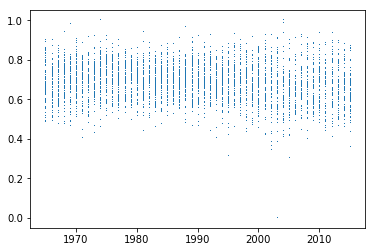

In [14]:
gloom_by_year = stats[['Year', 'Normalized Gloom Index']]
plt.plot(gloom_by_year['Year'], gloom_by_year['Normalized Gloom Index'], ',')
plt.show()

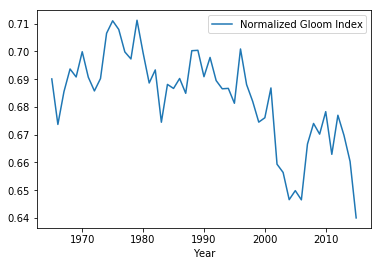

In [15]:
means = gloom_by_year.groupby(by="Year").mean().reset_index()
means.plot("Year", "Normalized Gloom Index")
plt.show()

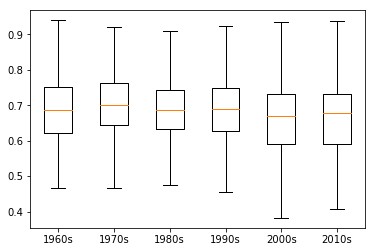

In [16]:
n60 = list(stats[stats['Year'] < 1970]['Normalized Gloom Index'])
n70 = list(stats[(stats['Year'] >= 1970) & (stats['Year'] < 1980)]['Normalized Gloom Index'])
n80 = list(stats[(stats['Year'] >= 1980) & (stats['Year'] < 1990)]['Normalized Gloom Index'])
n90 = list(stats[(stats['Year'] >= 1990) & (stats['Year'] < 2000)]['Normalized Gloom Index'])
n20 = list(stats[(stats['Year'] >= 2000) & (stats['Year'] < 2010)]['Normalized Gloom Index'])
n2_1 = list(stats[(stats['Year'] >= 2010)]['Normalized Gloom Index'])

labels = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

plt.boxplot([n60, n70, n80, n90, n20, n2_1], showfliers=False, labels=labels)
plt.show()

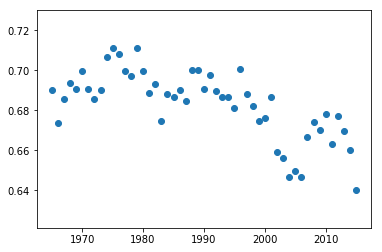

In [17]:
plt.scatter(means['Year'], means['Normalized Gloom Index'])
plt.show()

In [18]:
years = means["Year"]
gloom_index = means['Normalized Gloom Index']
z = np.polyfit(x=years, y=gloom_index, deg=3)
p = np.poly1d(z)
xp = range(1965, 2016)

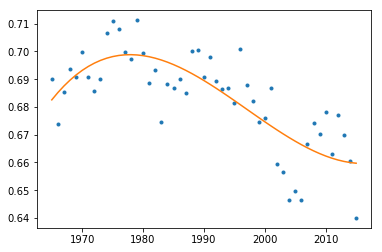

In [19]:
_ = plt.plot(years, gloom_index, '.', xp, p(xp), '-')
plt.show()

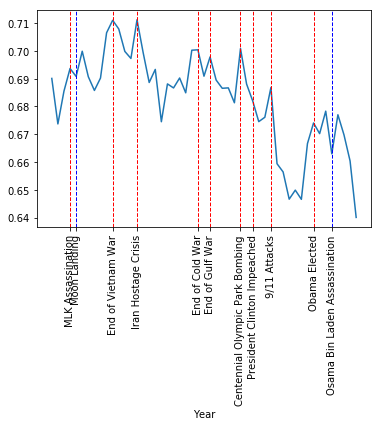

In [123]:
means = gloom_by_year.groupby(by="Year").mean().reset_index()
means.plot("Year", "Normalized Gloom Index", legend=False)

#MLK Assassination
plt.axvline(x=1968, color='r', linewidth=1, linestyle='--')

#Moon Landing
plt.axvline(x=1969, color='b', linewidth=1, linestyle='--')

#End of Vietnam War
plt.axvline(x=1975, color='r', linewidth=1, linestyle='--')

#Iran Hostage Crisis
plt.axvline(x=1979, color='r', linewidth=1, linestyle='--')

#End of Cold War and the Fall of the Berlin Wall
plt.axvline(x=1989, color='r', linewidth=1, linestyle='--')

#End of Gulf War
plt.axvline(x=1991, color='r', linewidth=1, linestyle='--')

#Centennial Olympic Park Bombing
plt.axvline(x=1996, color='r', linewidth=1, linestyle='--')

#President Clinton Impeachment
plt.axvline(x=1998, color='r', linewidth=1, linestyle='--')

#9/11 Attacks
plt.axvline(x=2001, color='r', linewidth=1, linestyle='--')

#Obama Election Assassination
plt.axvline(x=2008, color='r', linewidth=1, linestyle='--')

#Osama Bin Laden 
plt.axvline(x=2011, color='b', linewidth=1, linestyle='--')

plt.xticks([1968, 1969, 1975, 1979, 1989, 1991, 1996, 1998, 2001, 2008, 2011], ('MLK Assassination' , 'Moon Landing',
                                                        'End of Vietnam War',
                                                        'Iran Hostage Crisis', 'End of Cold War', 'End of Gulf War', 
                                                        'Centennial Olympic Park Bombing', 'President Clinton Impeached',
                                                        '9/11 Attacks', 'Obama Elected', 'Osama Bin Laden Assassination')
           , rotation=90 )



plt.show()